Rows deleted successfully - Hangingwall.
Rows deleted successfully - Footwall.
Processing complete - Figures loading...


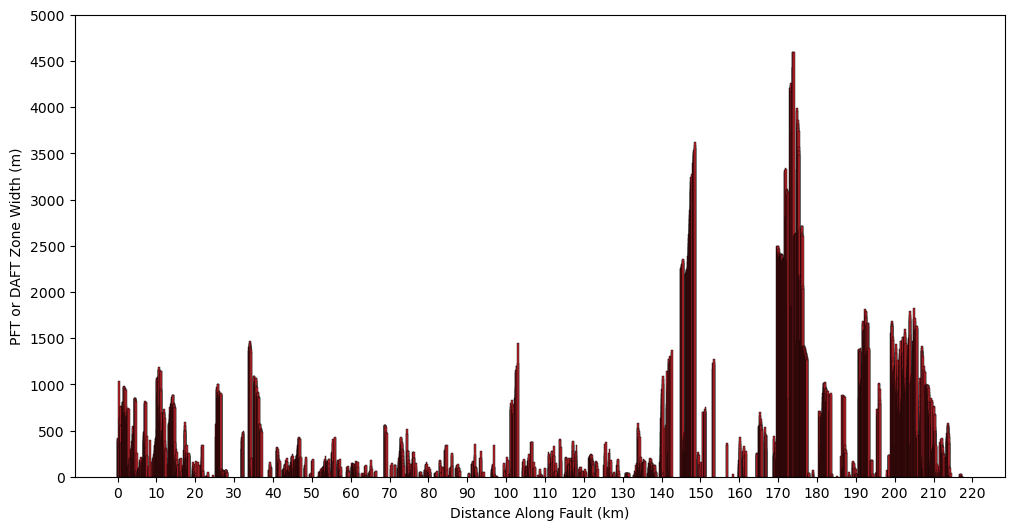

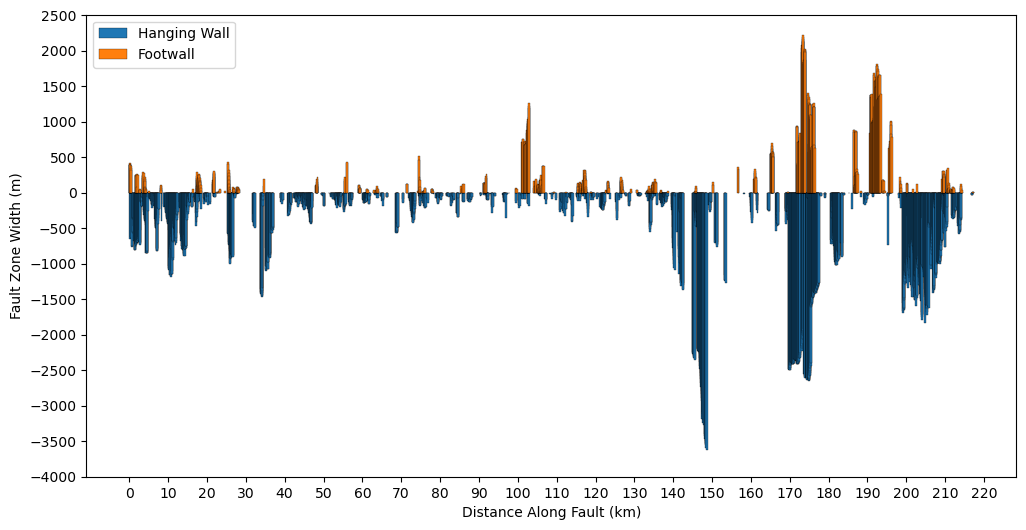

In [9]:
import arcpy
import math
import os
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# CONSTANTS & PATHS
# ---------------------------
# Define the folders where your input data are stored and where outputs will be saved.
# (Change these paths as appropriate for your environment.)
input_folder = r"C:\Users\Admin\OneDrive - The University of Melbourne\PhD\Github\AF_StructuralMaturity\input_shapefiles"  # Folder with your input shapefiles
output_folder = r"C:\Users\Admin\OneDrive - The University of Melbourne\PhD\Github\AF_StructuralMaturity\PFT_DAFT_ZoneWidth\Outputs"  # Folder where outputs will be saved

# Set the workspace for input files (optional, since we use full paths below)
arcpy.env.workspace = input_folder

# Define the spatial reference
spatial_ref = ('PROJCS["NZGD_2000_New_Zealand_Transverse_Mercator",'
               'GEOGCS["GCS_NZGD_2000",DATUM["D_NZGD_2000",'
               'SPHEROID["GRS_1980",6378137.0,298.257222101]],'
               'PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],'
               'PROJECTION["Transverse_Mercator"],'
               'PARAMETER["False_Easting",1600000.0],'
               'PARAMETER["False_Northing",10000000.0],'
               'PARAMETER["Central_Meridian",173.0],'
               'PARAMETER["Scale_Factor",0.9996],'
               'PARAMETER["Latitude_Of_Origin",0.0],'
               'UNIT["Meter",1.0]]')

# Define the input shapefiles (with the .shp extension)
psz_shapefile = os.path.join(input_folder, "PFTm.shp")
fault_shapefile = os.path.join(input_folder, "DAFTs.shp")

# Define the output shapefiles (ensure you add the .shp extension)
points_shapefile = os.path.join(output_folder, "PFT_50m_Points.shp")
transect_footwall_shapefile = os.path.join(output_folder, "Transect_Footwall.shp")
transect_hangingwall_shapefile = os.path.join(output_folder, "Transect_Hangingwall.shp")

# Other parameters
point_spacing = "50 Meters"
transect_length = 20000  # in meters

# ---------------------------
# STEP 1: Generate Points & Add XY
# ---------------------------
arcpy.management.GeneratePointsAlongLines(
    Input_Features=psz_shapefile,
    Output_Feature_Class=points_shapefile,
    Point_Placement="DISTANCE",
    Distance=point_spacing,
    Percentage=None,
    Include_End_Points="NO_END_POINTS",
    Add_Chainage_Fields="NO_CHAINAGE"
)
arcpy.management.AddXY(in_features=points_shapefile)

# ---------------------------
# STEP 2: Calculate Average Strike & Bearings
# ---------------------------
def calculate_bearings(shapefile):
    """
    Calculate the average strike and the two perpendicular bearings (first and inverse)
    from the input shapefile.
    """
    azimuths = []
    with arcpy.da.SearchCursor(shapefile, ["SHAPE@"]) as cursor:
        for row in cursor:
            shape = row[0]
            startPoint = shape.firstPoint
            endPoint = shape.lastPoint
            deltaX = endPoint.X - startPoint.X
            deltaY = endPoint.Y - startPoint.Y
            azimuth = math.degrees(math.atan2(deltaY, deltaX))
            if azimuth < 0:
                azimuth += 360
            azimuths.append(azimuth)
    average_strike = sum(azimuths) / len(azimuths)
    first_bearing = (average_strike - 90) % 360
    second_bearing = (average_strike + 90) % 360
    return first_bearing, second_bearing

first_bearing, second_bearing = calculate_bearings(psz_shapefile)

# Add and populate bearing fields in the points shapefile
for field_name, bearing_value in [("bearing", first_bearing), ("brng_inv", second_bearing)]:
    arcpy.management.AddField(in_table=points_shapefile, field_name=field_name, field_type="DOUBLE")
    with arcpy.da.UpdateCursor(points_shapefile, [field_name]) as cursor:
        for row in cursor:
            row[0] = bearing_value
            cursor.updateRow(row)

# ---------------------------
# STEP 3: Set Transect Length Field & Create Transects
# ---------------------------
arcpy.management.AddField(in_table=points_shapefile, field_name="distance", field_type="DOUBLE")
arcpy.management.CalculateField(in_table=points_shapefile, field="distance", expression=str(transect_length), expression_type="PYTHON3")

for bearing_field, output_shapefile in [("bearing", transect_footwall_shapefile), ("brng_inv", transect_hangingwall_shapefile)]:
    arcpy.management.BearingDistanceToLine(
        in_table=points_shapefile,
        out_featureclass=output_shapefile,
        x_field="POINT_X",
        y_field="POINT_Y",
        distance_field="distance",
        distance_units="METERS",
        bearing_field=bearing_field,
        bearing_units="DEGREES",
        line_type="PLANAR",
        id_field=None,
        spatial_reference=spatial_ref,
        attributes="NO_ATTRIBUTES"
    )

# ---------------------------
# STEP 4: Intersect Transects with Faults
# ---------------------------
intersect_hangingwall_shapefile = os.path.join(output_folder, "Fault_Intersect_Hangingwall.shp")
intersect_footwall_shapefile = os.path.join(output_folder, "Fault_Intersect_Footwall.shp")
intersect_inputs = {
    transect_hangingwall_shapefile: intersect_hangingwall_shapefile,
    transect_footwall_shapefile: intersect_footwall_shapefile
}
for transect, intersect_output in intersect_inputs.items():
    in_features = [transect, fault_shapefile]
    arcpy.analysis.PairwiseIntersect(
        in_features=in_features,
        out_feature_class=intersect_output,
        join_attributes="ONLY_FID",
        cluster_tolerance=None,
        output_type="POINT"
    )

# ---------------------------
# STEP 5: Split Transect Lines at Intersection Points
# ---------------------------
split_hangingwall_shapefile = os.path.join(output_folder, "Transect_Hangingwall_Split.shp")
split_footwall_shapefile = os.path.join(output_folder, "Transect_Footwall_Split.shp")
split_params = [
    (transect_hangingwall_shapefile, intersect_hangingwall_shapefile, split_hangingwall_shapefile),
    (transect_footwall_shapefile, intersect_footwall_shapefile, split_footwall_shapefile)
]
for in_transect, intersect_fc, split_output in split_params:
    arcpy.management.SplitLineAtPoint(
        in_features=in_transect,
        point_features=intersect_fc,
        out_feature_class=split_output,
        search_radius="1 Meters"
    )
for shp in [split_hangingwall_shapefile, split_footwall_shapefile]:
    if not arcpy.ListFields(shp, "SHAPE_LEN"):
        arcpy.management.AddField(shp, "SHAPE_LEN", "DOUBLE")
        arcpy.management.CalculateField(shp, "SHAPE_LEN", "!shape.length!", "PYTHON3")

# ---------------------------
# STEP 6: Delete Maximum ORIG_SEQ Features
# ---------------------------
def delete_max_orig_seq(input_shapefile):
    max_orig_seq = {}
    with arcpy.da.SearchCursor(input_shapefile, ["ORIG_FID", "ORIG_SEQ"]) as cursor:
        for orig_fid, orig_seq in cursor:
            if orig_fid not in max_orig_seq or orig_seq > max_orig_seq[orig_fid]:
                max_orig_seq[orig_fid] = orig_seq
    with arcpy.da.UpdateCursor(input_shapefile, ["FID", "ORIG_FID", "ORIG_SEQ"]) as cursor:
        for row in cursor:
            if row[2] == max_orig_seq[row[1]]:
                cursor.deleteRow()
for split_fc, msg in [(split_hangingwall_shapefile, "Hangingwall"), (split_footwall_shapefile, "Footwall")]:
    delete_max_orig_seq(split_fc)
    if arcpy.Exists("temp_layer"):
        arcpy.Delete_management("temp_layer")
    print(f"Rows deleted successfully - {msg}.")

# ---------------------------
# STEP 7: Calculate Statistics for Each Side
# ---------------------------
stats_hwall = os.path.join(output_folder, "Transect_HWall_Statistics.dbf")
stats_fwall = os.path.join(output_folder, "Transect_FWall_Statistics.dbf")
arcpy.analysis.Statistics(
    in_table=split_hangingwall_shapefile,
    out_table=stats_hwall,
    statistics_fields="SHAPE_LEN SUM",
    case_field="ORIG_FID"
)
arcpy.analysis.Statistics(
    in_table=split_footwall_shapefile,
    out_table=stats_fwall,
    statistics_fields="SHAPE_LEN SUM",
    case_field="ORIG_FID"
)

# Manually add a source field to each statistics table
arcpy.management.AddField(stats_fwall, "MERGE_SRC", "TEXT", field_length=50)
with arcpy.da.UpdateCursor(stats_fwall, ["MERGE_SRC"]) as cursor:
    for row in cursor:
        row[0] = "Transect_FWall_Statistics"
        cursor.updateRow(row)

arcpy.management.AddField(stats_hwall, "MERGE_SRC", "TEXT", field_length=50)
with arcpy.da.UpdateCursor(stats_hwall, ["MERGE_SRC"]) as cursor:
    for row in cursor:
        row[0] = "Transect_HWall_Statistics"
        cursor.updateRow(row)

# Merge the statistics tables
merged_stats = os.path.join(output_folder, "Transect_Statistics_Merge.dbf")
arcpy.management.Merge(
    inputs=[stats_fwall, stats_hwall],
    output=merged_stats
)

# (Optional) Run a final statistics tool if further aggregation is needed.
final_stats = os.path.join(output_folder, "Transect_FINAL_Statistics.dbf")
arcpy.analysis.Statistics(
    in_table=merged_stats,
    out_table=final_stats,
    statistics_fields="SUM_SHAPE_ SUM",  # The SUM of SHAPE_LEN becomes SUM_SHAPE_ in the stats table
    case_field="ORIG_FID"
)

# ---------------------------
# STEP 8: Calculate Distance Field with a Short Name
# ---------------------------
for table in [merged_stats, final_stats]:
    if not arcpy.ListFields(table, "DIST_KM"):
        arcpy.management.AddField(table, "DIST_KM", "DOUBLE")
    arcpy.management.CalculateField(
        in_table=table,
        field="DIST_KM",
        expression="!ORIG_FID! * 0.05",
        expression_type="PYTHON3"
    )

# ---------------------------
# STEP 9: Export Statistics to Excel
# ---------------------------
excel_output = os.path.join(output_folder, "Fault_FinalStats_Excel.xlsx")
arcpy.conversion.TableToExcel(
    Input_Table=f"{merged_stats};{final_stats}",
    Output_Excel_File=excel_output,
    Use_field_alias_as_column_header="NAME",
    Use_domain_and_subtype_description="CODE"
)
print("Processing complete - Figures loading...")

# ---------------------------
# FIGURE PLOT: Create a Bar Plot of Transect Data (Combined)
# ---------------------------
input_table = final_stats
x_field = "DIST_KM"
y_field = "SUM_SUM_SH"  # Adjust if your actual field is named differently

cursor = arcpy.da.SearchCursor(input_table, [x_field, y_field])
distances = []
shape_lengths = []
for row in cursor:
    distances.append(float(row[0]))
    shape_lengths.append(row[1])
del cursor

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.5
ax.bar(distances, shape_lengths, edgecolor="black", linewidth=0.3, width=bar_width, color="#C1272D")
ax.set_xlabel("Distance Along Fault (km)")
ax.set_ylabel("PFT or DAFT Zone Width (m)")
x_ticks = [10 * i for i in range(int(max(distances)) // 10 + 2)]
ax.set_xticks(x_ticks)
y_ticks = [500 * i for i in range(0, int(max(shape_lengths)) // 500 + 2)]
ax.set_yticks(y_ticks)

# Auto-save the separated plot
input_base = os.path.splitext(os.path.basename(fault_shapefile))[0]
separated_save_path = os.path.join(output_folder, f"{input_base}_Zone_Width.pdf")
fig.savefig(separated_save_path, dpi=300)
plt.show()


# ---------------------------
# FIGURE PLOT: Create a Bar Plot of Transect Data (Separated by Side)
# ---------------------------
table_name = merged_stats
data = {"Hanging Wall": [], "Footwall": []}
with arcpy.da.SearchCursor(table_name, ["MERGE_SRC", "DIST_KM", "SUM_SHAPE_"]) as cursor:
    for row in cursor:
        merge_src = row[0]
        distance = float(row[1])
        shape_length = row[2]
        if "Transect_HWall_Statistics" in merge_src:
            data["Hanging Wall"].append((-shape_length, distance))
        else:
            data["Footwall"].append((shape_length, distance))  # Negative for mirror effect

fig, ax = plt.subplots(figsize=(12, 6))
for group, values in data.items():
    if values:
        lengths, distances = zip(*values)
        ax.bar(distances, lengths, label=group, width=bar_width, edgecolor="black", linewidth=0.2)

ax.set_xlabel("Distance Along Fault (km)")
ax.set_ylabel("Fault Zone Width (m)")
ax.legend()

all_distances = []
for values in data.values():
    if values:
        _, d = zip(*values)
        all_distances.extend(d)
x_ticks = [10 * i for i in range(int(max(all_distances)) // 10 + 2)]
ax.set_xticks(x_ticks)
all_y = []
for group in data.values():
    for val, _ in group:
        all_y.append(val)
y_min = int(min(all_y) // 500 * 500)
y_max = int(max(all_y) // 500 * 500 + 500)
y_ticks = list(range(y_min, y_max+1, 500))
ax.set_yticks(y_ticks)

# Auto-save the separated plot
input_base = os.path.splitext(os.path.basename(fault_shapefile))[0]
separated_save_path = os.path.join(output_folder, f"{input_base}_HW_FW_Zone_Width.pdf")
fig.savefig(separated_save_path, dpi=300)
plt.show()


